# Kaggle - Digit Recognizer - Deep learning

## Classify handwritten digits using the famous MNIST data

Get the data here: https://www.kaggle.com/c/digit-recognizer 



### 1. Tflearn

#### Train from the datasets.mnist
Main source: https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_mnist.py

In [6]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [7]:
## TEST with the mnist data set
# Data loading and preprocessing
import tflearn.datasets.mnist as mnist

X, Y, testX, testY = mnist.load_data(one_hot=True)
X = X.reshape([-1, 28, 28, 1])
testX = testX.reshape([-1, 28, 28, 1])

Extracting mnist/train-images-idx3-ubyte.gz


//anaconda/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
//anaconda/lib/python3.5/site-packages/tflearn/datasets/mnist.py:52: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [3]:
# Building convolutional network
network = input_data(shape=[None, 28, 28, 1], name='input')
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = conv_2d(network, 64, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = local_response_normalization(network)
network = fully_connected(network, 128, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 256, activation='tanh')
network = dropout(network, 0.8)
network = fully_connected(network, 10, activation='softmax')
network = regression(network, optimizer='adam', learning_rate=0.01,
                     loss='categorical_crossentropy', name='target')

# Training
## 10 Epoch 
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y}, n_epoch=10,
           validation_set=({'input': testX}, {'target': testY}),
           snapshot_step=100, show_metric=True, run_id='convnet_mnist')

Training Step: 8600  | total loss: 0.42696
| Adam | epoch: 010 | loss: 0.42696 - acc: 0.9239 | val_loss: 0.11866 - val_acc: 0.9701 -- iter: 55000/55000
Training Step: 8600  | total loss: 0.42696
| Adam | epoch: 010 | loss: 0.42696 - acc: 0.9239 | val_loss: 0.11866 - val_acc: 0.9701 -- iter: 55000/55000
--


In [5]:
# Save a model (The most important is to save the learned weights, that what the model learn from the trainning)
model.save('model.tflearn')

## Visualization in TensorBoard

While writing a Tensorflow model and adding tensorboard summaries isn't very practical, TFLearn has the ability to self managed a lot of useful logs. Currently, TFLearn supports a verbose level to automatically manage summaries:

Type: $ tensorboard --logdir='/tmp/tflearn_logs' in your terminal.

Then you can visualize your model evolution here: http://0.0.0.0:6006 

Read more: https://www.tensorflow.org/how_tos/summaries_and_tensorboard/

![title](img/Graph.png)

![title](img/Accuracy.png)
![title](img/Loss.png)

## Visualization of the learned weights

![title](img/Weight.png)

Convolutional Neural Network for MNIST dataset classification task.  
**References:**  
   * Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.  

**Links:**  
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/  



### 2. Tensorflow

Now starting with the csv from Kaggle.

Sources: https://www.kaggle.com/mbeierling/digit-recognizer/my-first-nn-using-tensorflow - https://www.kaggle.com/mbeierling 

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [15]:
data = pd.read_csv("train.csv")

image_size => 784
image_width => 28
image_height => 28


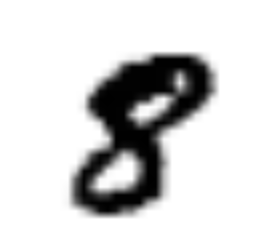

In [16]:
import matplotlib.cm as cm

images = data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image     
IMAGE_TO_DISPLAY = 10
display(images[IMAGE_TO_DISPLAY])

In [18]:
# define a "next batch" function that will return X image-label batches
def next_batch(c, last_index, df):
    '''
    c: amount of batches
    last_index: the index where to start getting the c datapoints
    df: dataframe to get the data from
    
    returns: tuple, where 
        index 0 holds c arrays with 784 pixel values
        index 1 holds c arrays with 10 label values in one-hot format
        
    This is built to work like the 'tensorflow.examples.tutorials.mnist.train.next_batch' function
    '''
    temp_data = df.loc[last_index : last_index + c - 1]
    last_index += c
    
    # Output has to be
    # tuple-> ( 
    #  np.array([<arrays of pixel values per image>]), 
    #  np.array([<arrays of one-hot target values>]) 
    # )
    
    temp_pixel_data = temp_data[temp_data.columns[1:]]
    temp_label_data = temp_data[temp_data.columns[:1]]
    
    one_hot_label_prior = temp_label_data.as_matrix().flatten() # will give us a flat array of labels
    
    count = len(one_hot_label_prior)
    one_hot_label_final = np.zeros((count, 10))
    one_hot_label_final[np.arange(count), one_hot_label_prior] = 1
    
    final_batch_out = (temp_pixel_data.as_matrix(), one_hot_label_final)
    
    return (last_index, final_batch_out)

# Let's do 2 test outputs:

curr_i = 0
curr_i, curr_batch = next_batch(4, curr_i, data)


curr_batch

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]]))

In [23]:
curr_i, curr_batch = next_batch(4, curr_i, data)

In [24]:
# Let's get a sample and render it
_, batch = next_batch(1, 0, data) # get first image; we don't care about our index-increment here

In [25]:
img_sample = batch[0][0] # get first tuple entry and first and only img pixel data array


In [27]:
# split data into training & testing sets using a random boolean mask
msk = np.random.rand(len(data)) < 0.8

train_data_split = data[msk]
test_data_split = data[~msk]

print('train_data_split: {}'.format( train_data_split.shape ))
print('test_data_split: {}'.format( test_data_split.shape ))
print('train to test: {:1.4f}%'.format( train_data_split.shape[0] * 100. / data.shape[0] ))

train_data_split: (33503, 785)
test_data_split: (8497, 785)
train to test: 79.7690%


In [28]:
# let's lay out our parameters
learning_rate = 0.001 # the lower the higher possibility for accurate training result
training_epochs = 50 # how many times we run learning. higher takes longer but yields better accuracy
batch_size = 100 # batches of training data

n_classes = 10 # there are 10 numbers: 0-9
n_samples = train_data_split.shape[0]
n_input = len(train_data_split.columns[1:]) # label column is no input

# Count of possible values for our hidden layers
n_hidden_1 = 256 # possible pixel values (8-bit colors)
n_hidden_2 = 256
# Now create our variables with randomization
weights = {
    'w1': tf.Variable( tf.random_normal( [n_input, n_hidden_1] )),
    'w2': tf.Variable( tf.random_normal( [n_hidden_1, n_hidden_2] )),
    'out': tf.Variable( tf.random_normal( [n_hidden_2, n_classes] ))
}

biases = {
    'b1': tf.Variable( tf.random_normal( [n_hidden_1] )),
    'b2': tf.Variable( tf.random_normal( [n_hidden_2] )),
    'out': tf.Variable( tf.random_normal( [n_classes] ))
}

X = tf.placeholder('float', shape=[None, n_input])
y = tf.placeholder('float', shape=[None, n_classes])
def multi_layer_perceptron(data_input, weights, biases):
    
    # LAYER 1 with some more explanations:
    
    # INPUTS * WEIGHTS + BIASES
    layer_1 = tf.add(tf.matmul(data_input, weights['w1']), biases['b1'])
    
    # Activation using RELU, which is just f(x) = max(0, x)
    layer_1 = tf.nn.relu(layer_1)
    
    # Layer 2
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Output Layer
    layer_out = tf.matmul(layer_2, weights['out']) + biases['out']
    
    return layer_out

In [29]:
# Construct the optimizer, which will essentially tune weights in our perceptron

# Instance of our model with variables and placeholders
pred = multi_layer_perceptron(X, weights, biases)

# cost function, we use a mean over the cross entropy
cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( pred, y ))

# our final optimizer. AdamOptimizer is quite new. More here: https://arxiv.org/pdf/1412.6980v8.pdf
optimizer = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize(cost)

In [30]:
# Create an interactive session, which works best for this notebook
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

for epoch in range(training_epochs):
    
    # optional: we'll print out the cost at each epoch
    avg_cost = 0.
    
    # number of batches we need to run to iterate over all samples
    batch_total = int( n_samples / batch_size )
    
    batch_idx = 0
    
    for idx in range(batch_total):
        
        # get next batch, assigning batch index to new incremented value
        batch_idx, batch = next_batch(batch_size, batch_idx, train_data_split)
        
        # use tuple unpacking to get the data and labels seperately
        batch_X, batch_y = batch
        
        # run our session with our defined optimizer & cost tensors, as well as data & labels
        _, local_cost = sess.run( [optimizer, cost], feed_dict={ X: batch_X, y: batch_y })
        
        avg_cost += (local_cost / batch_total)
        
    print("{}. epoch with cost of {}".format(epoch + 1, avg_cost))
    
print("Training Complete!")

1. epoch with cost of 53659.67409048506
2. epoch with cost of 14766.505730381301
3. epoch with cost of 9201.76233019473
4. epoch with cost of 6446.691996833463
5. epoch with cost of 4658.72544296037
6. epoch with cost of 3452.2342145094212
7. epoch with cost of 2572.4844423151744
8. epoch with cost of 1912.907166629052
9. epoch with cost of 1420.896105921447
10. epoch with cost of 1048.1081826452
11. epoch with cost of 804.3646602334372
12. epoch with cost of 600.9037010762227
13. epoch with cost of 443.77731292244874
14. epoch with cost of 332.97188333579874
15. epoch with cost of 272.54872485879656
16. epoch with cost of 213.7219982805536
17. epoch with cost of 180.7914135021949
18. epoch with cost of 141.07541294133486
19. epoch with cost of 130.6873433511648
20. epoch with cost of 133.25711613840133
21. epoch with cost of 108.58903994987263
22. epoch with cost of 87.13348291374515
23. epoch with cost of 94.2343515015805
24. epoch with cost of 129.5498562382228
25. epoch with cost o

In [31]:
# transform dataframe to needed array representation again
# TODO should be combined with the same process done in the next_batch function

test_data = test_data_split[test_data_split.columns[1:]]
test_label = test_data_split[test_data_split.columns[:1]]

one_hot_test_label_prior = test_label.as_matrix().flatten() # will give us a flat array of labels

test_count = len(one_hot_test_label_prior)
one_hot_test_label_final = np.zeros((test_count, 10))
one_hot_test_label_final[np.arange(test_count), one_hot_test_label_prior] = 1

correct_preds = tf.equal( tf.argmax(pred, 1), tf.argmax(y, 1) )

# will give us boolean type, we need numerical to calculate accuracy using mean
correct_preds = tf.cast(correct_preds, 'float')

# create our accuracy tensor
accuracy = tf.reduce_mean(correct_preds)

# evaluate accuracy using our test split data
accuracy.eval( feed_dict={ X: test_data, y: one_hot_test_label_final } )

0.94951159

# Make predictions on the test dataset


In [32]:
# First we need our test data
test_data = pd.read_csv("test.csv")

In [33]:
# get the label-index with highest probability (in our case index = predicted number)
maximum_probability = tf.argmax(y,1)

# actually predict our labels using the test dataset
predicted_lables = pred.eval( feed_dict={ X: test_data.as_matrix() } )

# then transform those predictions into our final array of predicted labels
predicted_labels = maximum_probability.eval( feed_dict={ y: predicted_lables })

# our final predicted labels array looks good
predicted_labels

array([2, 0, 9, ..., 3, 9, 2])

In [34]:
# save results
# we need to have an additional incremental id column for the submission file
result_array = np.c_[ range(1,len(test_data)+1), predicted_labels]

np.savetxt('submission.csv', result_array, delimiter=',', 
           header='ImageId,Label', comments = '', fmt='%d')